In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
datasets_paths = []
import os
for dirname, _, filenames in os.walk('/kaggle/input/final-datasets'):
    for filename in filenames:
        datasets_paths.append(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numbers
import itertools
import logging
import re
# from joblib import Parallel, delayed

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.utils.validation import has_fit_parameter
from sklearn.utils.validation import _check_sample_weight
from sklearn.utils.validation import check_random_state
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.validation import check_array
from sklearn.utils.random import sample_without_replacement
from sklearn.tree._tree import DTYPE

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.stats import uniform, randint
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import make_scorer

from collections import defaultdict
import numpy as np
import math

import pandas as pd

In [3]:
import sklearn

In [4]:
sklearn.__version__

'0.23.1'

In [5]:
MAX_INT = np.iinfo(np.int32).max
PA_RHO = 0.00001
FOREST_PA_RANDOM_STATE = 42
RANDOM_FOREST_RANDOM_STATE = 31
LOG_LEVEL = logging.INFO

CV_RANDOM_STATE = 1989
CV_ITERS = 50
INNER_CV_FOLDS = 3
OUTER_CV_FOLDS = 10

In [6]:
logger = logging.getLogger("ForestPA")
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(LOG_LEVEL)
formatter = logging.Formatter('%(asctime)s : %(levelname)s : %(name)s : %(message)s')
ch.setFormatter(formatter)
if logger.handlers:
    logger.handlers = []
logger.addHandler(ch)

# PA Forest

## Single Tree Inducer
> #### CART based with modification: split by maximum "merit-value" - split-criteria (GINI) * attribute's weight

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

# code partially inspired by https://github.com/joachimvalente/decision-tree-cart/blob/master/minimal_cart.py, but 80% modified :[]
class Node:
    def __init__(self, num_samples_per_class, depth):
        self.num_samples_per_class = num_samples_per_class
        self.feature_index = 0
        self.feature_name = None
        self.threshold = 0
        self.depth = depth
        self.left = None
        self.right = None


class CARTDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    @_deprecate_positional_args
    def __init__(self, *,
                 criterion="gini",
                 splitter="best",
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.,
                 max_features=None,
                 random_state=None,
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.,
                 min_impurity_split=None,
                 class_weight=None,
                 sample_weight=None,
                 presort='deprecated',
                 feature_names=None,
                 ccp_alpha=0.0):
        self.criterion = criterion
        self.splitter = splitter
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf ##
        self.max_features = max_features ## unused. Implemented in the forest level. In PA Forest not relevant
        self.max_leaf_nodes = max_leaf_nodes ## used for best-first build - not supported here
        self.random_state = random_state
        self.min_impurity_decrease = min_impurity_decrease
        self.min_impurity_split = min_impurity_split ## dep.
        self.class_weight = class_weight
        self.sample_weight = sample_weight
        self.presort = presort ## dep.
        self.feature_names=feature_names
        self.ccp_alpha = ccp_alpha ##


    def fit(self, X, y, attributes_weights, sample_weight=None):
        # TODO: implement sample_weight logic
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
                
        self.classes_ = unique_labels(y)
        self.n_classes_ = len(self.classes_)
        self.n_features_ = X.shape[1]
        self.nodes_ = []
        self.tree_ = self._build_tree(X, y, attributes_weights)

    def predict(self, X, check_input):
        # Check is fit had been called
        check_is_fitted(self)
        X = self._validate_X_predict(X, check_input)
        # Input validation
        X = check_array(X)
        
        return [self._predict(inputs) for inputs in X]
    
    def predict_proba(self, X, check_input):
        # Check is fit had been called
        check_is_fitted(self)
        # Input validation
        X = self._validate_X_predict(X, check_input)
        
        return [self._predict_proba(inputs) for inputs in X]            
    
    def _validate_X_predict(self, X, check_input):
        """Validate X whenever one tries to predict, apply, predict_proba"""
        if check_input:
            X = check_array(X, dtype=DTYPE, accept_sparse="csr")
            if issparse(X) and (X.indices.dtype != np.intc or
                                X.indptr.dtype != np.intc):
                raise ValueError("No support for np.int64 index based "
                                 "sparse matrices")

        n_features = X.shape[1]
        if self.n_features_ != n_features:
            raise ValueError("Number of features of the model must "
                             "match the input. Model n_features is %s and "
                             "input n_features is %s "
                             % (self.n_features_, n_features))

        return X
    
    def _calc_impurity_gain(self, sample_sorted_idx, num_left, num_right, total_parent_samples, parent_class_dist):
        if self.criterion == "gini":
            parent_impurity = 1.0 - sum((n / total_parent_samples) ** 2 for n in parent_class_dist)
            
            impurity_left = 1.0 - sum(
                (num_left[x] / sample_sorted_idx) ** 2 for x in self.classes_
            )
            impurity_right = 1.0 - sum(
                (num_right[x] / (total_parent_samples - sample_sorted_idx)) ** 2 for x in self.classes_
            )
            impurity = (sample_sorted_idx * impurity_left + (total_parent_samples - sample_sorted_idx) * impurity_right) / total_parent_samples
        else:
            raise NotImplementedError("impurity for criterion {} is not supported...".format(self.criterion))
        
        return parent_impurity - impurity

    def _best_split(self, X, y, attributes_weights, total_parent_samples, parent_class_dist, min_samples_leaf):
        best_idx, best_thr, best_impurity_gain = None, None, 0
        
        for idx in range(self.n_features_):
            best_feature_impurity_gain = 0
            best_feature_thr = None
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * self.n_classes_
            num_right = parent_class_dist.copy()
            for i in range(1, total_parent_samples):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                if thresholds[i] == thresholds[i - 1]:
                    continue
                
                impurity_gain = self._calc_impurity_gain(i, num_left, num_right, total_parent_samples, parent_class_dist)
                
                if impurity_gain > best_feature_impurity_gain and sum(num_left)>=min_samples_leaf and sum(num_right)>=min_samples_leaf:                    
                    best_feature_impurity_gain = impurity_gain
                    best_feature_thr = (thresholds[i] + thresholds[i - 1]) / 2
            
            best_feature_impurity_gain *= attributes_weights[idx]
            
            if best_feature_impurity_gain > best_impurity_gain:
                best_impurity_gain = best_feature_impurity_gain
                best_thr = best_feature_thr
                best_idx = idx
                    
        return best_idx, best_thr, best_impurity_gain

    def _build_tree(self, X, y, attributes_weights, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in self.classes_]
        node = Node(num_samples_per_class=num_samples_per_class, depth=depth)
        
        total_samples = y.size
        class_dist = [np.sum(y == c) for c in range(self.n_classes_)]        
        idx, thr, impurity_gain = self._best_split(X, y, attributes_weights, total_parent_samples=total_samples, parent_class_dist=class_dist, 
                                                   min_samples_leaf=self.min_samples_leaf)

        # TODO: add more conditions according to provided parameters in the constructor
        is_leaf = (self.max_depth and depth >= self.max_depth) or \
                  (total_samples < self.min_samples_split) or \
                  (impurity_gain < self.min_impurity_decrease)
        
        if not is_leaf and idx is not None:
            indices_left = X[:, idx] < thr
            X_left, y_left = X[indices_left], y[indices_left]
            X_right, y_right = X[~indices_left], y[~indices_left]
            node.feature_index = idx
            node.feature_name = self.feature_names[idx]
            node.threshold = thr
            node.left = self._build_tree(X_left, y_left, attributes_weights, depth + 1)
            node.right = self._build_tree(X_right, y_right, attributes_weights, depth + 1)
        self.nodes_.append(node)
        return node
    
    def _get_final_predict_node(self, inputs):
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node
    
    def _predict(self, inputs):
        final_predict_node = self._get_final_predict_node(inputs)
        return np.argmax(final_predict_node.num_samples_per_class)
    
    def _predict_proba(self, inputs):
        final_predict_node = self._get_final_predict_node(inputs)
        num_samples_per_class = np.array(final_predict_node.num_samples_per_class)
        return num_samples_per_class/num_samples_per_class.sum()

In [8]:
# from https://github.com/scikit-learn/scikit-learn/blob/fd237278e895b42abe8d8d09105cbb82dc2cbba7/sklearn/ensemble/_bagging.py
def _generate_indices(random_state, bootstrap, n_population, n_samples):
    """Draw randomly sampled indices."""
    # Draw sample indices
    if bootstrap:
#         indices = random_state.randint(0, n_population, n_samples)
        indices = random_state.choice(range(0, n_population), size=n_samples, replace=True)
    else:
#         indices = sample_without_replacement(n_population, n_samples, random_state=random_state)
        indices = random_state.choice(range(0, n_population), size=n_samples, replace=False)

    return indices

def _generate_bagging_indices(random_state, bootstrap_features,
                              bootstrap_samples, n_features, n_samples,
                              max_features, max_samples):
    """Randomly draw feature and sample indices."""
    # Get valid random state
    random_state = check_random_state(random_state)

    # Draw indices
    feature_indices = _generate_indices(random_state, bootstrap_features,
                                        n_features, max_features)
    sample_indices = _generate_indices(random_state, bootstrap_samples,
                                       n_samples, max_samples)

    return feature_indices, sample_indices

## Main Ensemble - PA Forest

In [9]:
class ForestPA(BaggingClassifier):
    @_deprecate_positional_args
    def __init__(self,
                 base_estimator=None,
                 n_estimators=10,
                 oob_score=False,
                 warm_start=False,
                 n_jobs=None,
                 random_state=None,
                 max_depth=None,
                 min_samples_split=None,
                 min_samples_leaf=None,
                 min_impurity_decrease=None,
                 verbose=0):
        super().__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators,
            max_samples=1.0,
            max_features=1.0,
            bootstrap=True,
            bootstrap_features=False,
            oob_score=oob_score,
            warm_start=warm_start,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose)
        self.estimators_ = []
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
#             self.base_estimator.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
#             self.base_estimator.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease
#             self.base_estimator.min_impurity_decrease = min_impurity_decrease
        
    def _update_attributes_weights(self, curr_attributes_weights, last_estimator, before_last_estimator):
        if last_estimator is None:
            return curr_attributes_weights
        
        new_attributes_weights = curr_attributes_weights.copy()
        new_attributes_weights_upgrade = np.zeros(len(new_attributes_weights))
        
        last_estimator_nodes = last_estimator.nodes_
        last_estimator_nodes_feature_index_dict = defaultdict(list)
        for node in last_estimator_nodes:
            last_estimator_nodes_feature_index_dict[node.feature_index].append(node)
#         logger.debug("(LAST ESTIMATOR) The feature-index to nodes dict:\n{}".format(last_estimator_nodes_feature_index_dict))
        for feature_index, nodes in last_estimator_nodes_feature_index_dict.items():
            feature_new_weight = np.Inf
            for node in nodes:
                node_level = node.depth + 1
                if node_level == 1: # i.e. root
                    range_lower_limit = 0
                else:
                    range_lower_limit = math.exp(-1/(node_level-1))+PA_RHO
                range_upper_limit = math.exp(-1/node_level)
                feature_random_weight = self.random_state.uniform(range_lower_limit, range_upper_limit)
#                 logger.debug("new random weight for feature {}, sampled from range [{}, {}] is {}".format(feature_index, 
#                                                                                                           range_lower_limit, 
#                                                                                                           range_upper_limit, 
#                                                                                                           feature_random_weight))
                if feature_random_weight < feature_new_weight:
#                     logger.debug("new random weight {} for feature {} smaller than current {}, and was registered!".format(feature_random_weight, 
#                                                                                                                            feature_index,
#                                                                                                                            feature_new_weight))
                    feature_new_weight = feature_random_weight
                    new_attributes_weights[feature_index] = feature_new_weight
        
        
        if before_last_estimator:
            before_last_estimator_nodes = last_estimator.nodes_
            before_last_estimator_nodes_feature_index_dict = defaultdict(list)
            for node in before_last_estimator_nodes:
                before_last_estimator_nodes_feature_index_dict[node.feature_index].append(node)
#             logger.debug("(BEFORE LAST ESTIMATOR) The feature-index to nodes dict:\n{}".format(before_last_estimator_nodes_feature_index_dict))
            before_last_estimator_height = max([n.depth for n in before_last_estimator_nodes])
            for feature_index, nodes in before_last_estimator_nodes_feature_index_dict.items():
                if feature_index not in last_estimator_nodes_feature_index_dict:
                    logger.debug("the feature {} did not appear in last tree".format(feature_index))
                    curr_attribute_weight = curr_attributes_weights[feature_index]
                    attribute_min_level = min([n.depth for n in nodes]) ## THE PAPER DOESN'T STATE WHAT LEVEL SHOULD BE CONSIDERED FOR ATTIRBUTES IN MULTIPLE LEVELS
                    if curr_attribute_weight < 1:
                        sigma_weight_update = (1 - curr_attribute_weight) / ((before_last_estimator_height + 1) - attribute_min_level)
                        feature_new_weight = new_attributes_weights[feature_index] + sigma_weight_update
                        logger.debug("the feature {} had weight < 1, therefore its update is {} causing a new weight: {}".format(feature_index, 
                                                                                                                                 sigma_weight_update,
                                                                                                                                 feature_new_weight))
                        new_attributes_weights[feature_index] = feature_new_weight
                    else:
                        logger.debug("the feature {} had weight >= 1, therefore no update applied and downgraded back to 1".format(feature_index))
                        new_attributes_weights[feature_index] = 1

        return new_attributes_weights
        
    def _build_forest_pa_estimators(self, verbose, ensemble, X, y, sample_weight, seeds, n_estimators):
        n_samples, n_features = X.shape
        max_features = ensemble._max_features
        max_samples = ensemble._max_samples
        bootstrap = ensemble.bootstrap
        bootstrap_features = ensemble.bootstrap_features
        support_sample_weight = has_fit_parameter(ensemble.base_estimator_,
                                                  "sample_weight")
        if not support_sample_weight:
            raise ValueError("The base estimator doesn't support sample weight")
            
        # Build estimators
        estimators = []
        estimators_features = []
        last_estimator = None
        before_last_estimator = None
        
        curr_sample_weight = sample_weight.copy()
        curr_attributes_weights = np.ones(X.shape[1])
        for estimator_i in range(n_estimators):
            if verbose > 1:
                logger.info("Building estimator {} of {}...".format(estimator_i+1, n_estimators))
            random_state = seeds[estimator_i]
            estimator = ensemble._make_estimator(append=False, random_state=random_state)
            if len(estimators) > 0:
                last_estimator = estimators[-1]
            if len(estimators) > 1:
                before_last_estimator = estimators[-2]
            
            # Draw random sample indices
            try: # because "nodes" attribute only relevant for our modified CART
                curr_attributes_weights = self._update_attributes_weights(curr_attributes_weights, last_estimator, before_last_estimator)
            except:
                pass
#             logger.debug("attributes weights:\n{}".format(curr_attributes_weights))
            features, indices = _generate_bagging_indices(random_state,
                                                          bootstrap_features,
                                                          bootstrap, n_features,
                                                          n_samples, max_features,
                                                          max_samples)
            
            
            # Draw samples, using sample weights, and then fit
            if sample_weight is None:
                raise Exception("sample_weight is None!")
            
            # STEP 1: Generate Bootstrap Sample
            sample_counts = np.bincount(indices, minlength=n_samples)

            # STEP 2: Generate Decision Tree (base estimator)
            try: # because "attributes_weights" only relevant for our modified CART
                estimator.fit(X[:, features], y, sample_weight=curr_sample_weight*sample_counts, attributes_weights=curr_attributes_weights)
            except:
                estimator.fit(X[:, features], y, sample_weight=curr_sample_weight*sample_counts)
                
            
            estimators.append(estimator)
            estimators_features.append(features)
            
        return estimators, estimators_features
    
    def _fit(self, X, y, max_samples=None, max_depth=None, sample_weight=None):
        max_depth = max_depth or self.max_depth
        random_state = check_random_state(self.random_state)
        X, y = self._validate_data(
            X, y, accept_sparse=['csr', 'csc'], dtype=None,
            force_all_finite=False, multi_output=True
        )
        if sample_weight is None:
            sample_weight = _check_sample_weight(sample_weight=None, X=X, dtype=None)
        
        # Remap output
        n_samples, self.n_features_ = X.shape
        self._n_samples = n_samples
        y = self._validate_y(y)

        # Check parameters
        self._validate_estimator()
        
        if max_depth is not None:
            self.base_estimator_.max_depth = max_depth
            
        if self.min_samples_split:
            self.base_estimator_.min_samples_split = self.min_samples_split
            
        if self.min_samples_leaf:
            self.base_estimator_.min_samples_leaf = self.min_samples_leaf
            
        if self.min_impurity_decrease:
            self.base_estimator_.min_impurity_decrease = self.min_impurity_decrease
        
        if max_samples is None:
            max_samples = self.max_samples
        elif not isinstance(max_samples, numbers.Integral):
            max_samples = int(max_samples * X.shape[0])
        if not (0 < max_samples <= X.shape[0]):
            raise ValueError("max_samples must be in (0, n_samples]")
        self._max_samples = max_samples
              
        # Validate max_features
        if isinstance(self.max_features, numbers.Integral):
            max_features = self.max_features
        elif isinstance(self.max_features, np.float):
            max_features = self.max_features * self.n_features_
        else:
            raise ValueError("max_features must be int or float")
        if not (0 < max_features <= self.n_features_):
            raise ValueError("max_features must be in (0, n_features]")
        max_features = max(1, int(max_features))
        self._max_features = max_features
        
        #TODO: handle warm start
        self.estimators_ = []
        self.estimators_features_ = []            
        
        seeds = random_state.randint(MAX_INT, size=self.n_estimators)
        self._seeds = seeds
        
        all_results = self._build_forest_pa_estimators(self.verbose, self, X, y, sample_weight, seeds, self.n_estimators)
#         self.estimators_ += list(itertools.chain.from_iterable(
#             t[0] for t in all_results))
#         self.estimators_features_ += list(itertools.chain.from_iterable(
#             t[1] for t in all_results))
        self.estimators_ = all_results[0]
        self.estimators_features_ = all_results[1]

        if self.oob_score:
            self._set_oob_score(X, y)

        return self
    
    def _partition_estimators(self, n_estimators, n_jobs):
        """Private function used to partition estimators between jobs."""
        # Compute the number of jobs
        n_jobs = min(effective_n_jobs(n_jobs), n_estimators)

        # Partition estimators between jobs
        n_estimators_per_job = np.full(n_jobs, n_estimators // n_jobs,
                                       dtype=np.int)
        n_estimators_per_job[:n_estimators % n_jobs] += 1
        starts = np.cumsum(n_estimators_per_job)

        return n_jobs, n_estimators_per_job.tolist(), [0] + starts.tolist()
    
    def predict_proba(self, X, check_input=False):
        check_is_fitted(self)
        X = X.astype(np.float32)
        # Check data
        X = check_array(
            X, accept_sparse=['csr', 'csc'], dtype=None,
            force_all_finite=False
        )

        if self.n_features_ != X.shape[1]:
            raise ValueError("Number of features of the model must "
                             "match the input. Model n_features is {0} and "
                             "input n_features is {1}."
                             "".format(self.n_features_, X.shape[1]))

        # Parallel loop
#         n_jobs, n_estimators, starts = self._partition_estimators(self.n_estimators,
#                                                                   self.n_jobs)

#         all_proba = Parallel(n_jobs=n_jobs, verbose=self.verbose,
#                              **self._parallel_args())(
#             delayed(self._parallel_predict_proba)(
#                 self.estimators_[starts[i]:starts[i + 1]],
#                 self.estimators_features_[starts[i]:starts[i + 1]],
#                 X,
#                 self.n_classes_)
# #             for i in range(n_jobs))

        n_samples = X.shape[0]
        all_proba = np.zeros((n_samples, self.n_classes_))

        for estimator, features in zip(self.estimators_, self.estimators_features_):
            if hasattr(estimator, "predict_proba"):
                proba_estimator = estimator.predict_proba(X[:, features], check_input=check_input)

                if self.n_classes_ == len(estimator.classes_):
                    all_proba += proba_estimator

                else:
                    all_proba[:, estimator.classes_] += \
                        proba_estimator[:, range(len(estimator.classes_))]

            else:
                # Resort to voting
                predictions = estimator.predict(X[:, features], check_input=check_input)

                for i in range(n_samples):
                    all_proba[i, predictions[i]] += 1
                    
        # Reduce
        proba = all_proba / self.n_estimators

        return proba

# Data Preprocessing

### handle ID cols, NaN cols, known to drop cols

In [10]:
def drop_special_cols(dataset, drop_id_cols=False, dropna_rows_params=None, dropna_cols_params=None):
    # search for ID columns (by name of column, no statistical triks)
    new_dataset = dataset.copy()
    id_patter = r'((^|[^a-zA-Z])id([^a-zA-Z]|$))|(^id[^a-zA-Z])'
    id_cols = [c for c in new_dataset.columns if re.search(id_patter,  c, flags=re.IGNORECASE)]
    if len(id_cols) > 0:
        if drop_id_cols:
            new_dataset = new_dataset.drop(columns=id_cols)
            logger.info("Dropped from dataset {} id columns: {}".format(dataset.name, id_cols))
    orig_rows = len(new_dataset)
    orig_cols = new_dataset.columns
    if dropna_rows_params:
        new_dataset = new_dataset.dropna(axis=0, **dict(dropna_rows_params))
    if dropna_cols_params:
        temp = new_dataset.dropna(axis=1, **dict(dropna_cols_params))
        if not temp.empty:
            new_dataset = temp
    if (orig_rows - len(new_dataset)) > 0:
        logger.info("NaN drops: Dropped from dataset {} - {} rows".format(dataset.name, len(new_dataset) - orig_rows))
    if (len(orig_cols) - len(new_dataset.columns)) > 0:
        logger.info("NaN drops: Dropped from dataset {} - {} cols ({})".format(dataset.name, len(new_dataset.columns) - len(orig_cols),
                                                                                   list(set(orig_cols) - set(new_dataset.columns))))
    new_dataset.name = dataset.name
    return new_dataset

### Custom Imputers to support get_feature_names API call

In [11]:
class SimpleImputerWithNames(SimpleImputer):
    def get_feature_names(self):
        return self.X.columns.tolist()
    
    def fit(self, X, y=None):
        """Fit the imputer on X.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            Input data, where ``n_samples`` is the number of samples and
            ``n_features`` is the number of features.
        Returns
        -------
        self : SimpleImputerWithNames
        """
        self.X = X
        X = self._validate_input(X, in_fit=True)
        super()._fit_indicator(X)

        # default fill_value is 0 for numerical input and "missing_value"
        # otherwise
        if self.fill_value is None:
            if X.dtype.kind in ("i", "u", "f"):
                fill_value = 0
            else:
                fill_value = "missing_value"
        else:
            fill_value = self.fill_value

        # fill_value should be numerical in case of numerical input
        if (self.strategy == "constant" and
                X.dtype.kind in ("i", "u", "f") and
                not isinstance(fill_value, numbers.Real)):
            raise ValueError("'fill_value'={0} is invalid. Expected a "
                             "numerical value when imputing numerical "
                             "data".format(fill_value))

        if sparse.issparse(X):
            # missing_values = 0 not allowed with sparse data as it would
            # force densification
            if self.missing_values == 0:
                raise ValueError("Imputation not possible when missing_values "
                                 "== 0 and input is sparse. Provide a dense "
                                 "array instead.")
            else:
                self.statistics_ = self._sparse_fit(X,
                                                    self.strategy,
                                                    self.missing_values,
                                                    fill_value)
        else:
            self.statistics_ = self._dense_fit(X,
                                               self.strategy,
                                               self.missing_values,
                                               fill_value)
        return self

### Transformer to be applied on dataset for preprocessing

In [12]:
class PreprocessTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,
                 preprocess_numeric_imputer=SimpleImputerWithNames(strategy="median"), 
                 preprocess_categorical_imputer=SimpleImputerWithNames(strategy="constant", fill_value="MISSING"),
                 preprocess_categorical_ohe=OneHotEncoder(handle_unknown="ignore")):
        self.preprocess_numeric_imputer = preprocess_numeric_imputer
        self.preprocess_categorical_imputer = preprocess_categorical_imputer
        self.preprocess_categorical_ohe = preprocess_categorical_ohe

    # the arguments are ignored anyway, so we make them optional
    def fit(self, X, y=None):
        numeric_features = X.select_dtypes(np.number).columns
        self.numeric_features = numeric_features
        categorical_features = list(set(X.columns) - set(numeric_features))
        self.categorical_features = categorical_features
        na_transformers = []
        na_transformer = None
        ohe_transformer = None
        if self.preprocess_categorical_imputer and len(categorical_features)>0:
            na_transformers.append(("categorical_imputer", self.preprocess_categorical_imputer, categorical_features))
        if self.preprocess_numeric_imputer and len(numeric_features)>0:
            na_transformers.append(("numeric_imputer", self.preprocess_numeric_imputer, numeric_features))
        if na_transformers:
            na_transformer = ColumnTransformer(transformers=na_transformers,
                                               remainder="passthrough",
                                               n_jobs=-1)
            X = na_transformer.fit_transform(X)
            X = pd.DataFrame(X, columns=na_transformer.get_feature_names())
            numeric_features = [c for c in X.columns if "numeric" in c]
            categorical_features = list(set(X.columns) - set(numeric_features))
            X[numeric_features] = X[numeric_features].astype('float64')
        if self.preprocess_categorical_ohe and len(categorical_features):
            ohe_transformer = ColumnTransformer(transformers=[("categorical_ohe", self.preprocess_categorical_ohe, categorical_features)],
                                                remainder="passthrough",
                                                n_jobs=-1)
            ohe_transformer.fit(X)
            
        self.na_transformer = na_transformer
        self.ohe_transformer = ohe_transformer
        return self

    def transform(self, X):
        transformed_X = X.copy()
        numeric_features = self.numeric_features
        categorical_features = self.categorical_features
        if self.na_transformer:
            transformed_X = self.na_transformer.transform(transformed_X)
            transformed_X = pd.DataFrame(transformed_X, columns=self.na_transformer.get_feature_names())
            numeric_features = [c for c in transformed_X.columns if "numeric" in c]
            categorical_features = list(set(transformed_X.columns) - set(numeric_features))
            transformed_X[numeric_features] = transformed_X[numeric_features].astype('float64')
        if self.ohe_transformer:
            orig_cols = transformed_X.columns
            transformed_X = self.ohe_transformer.transform(transformed_X)
            if not isinstance(transformed_X, np.ndarray):
                transformed_X = transformed_X.toarray()
            transformed_X = pd.DataFrame(transformed_X, columns=self.ohe_transformer.get_feature_names())
            transformed_X_ohe_cols = [c for c in transformed_X.columns if "categorical_ohe" in c]
            transformed_X_ohe_cols_correct = self.ohe_transformer.transformers_[0][1].get_feature_names(categorical_features)
            transformed_X = transformed_X.rename(columns=dict(zip(transformed_X_ohe_cols, transformed_X_ohe_cols_correct)))
            
        return transformed_X

### utility functions for custom metrics in cross-validation report

In [13]:
def get_cnf_matrix_multiclass_metrics(cnf_matrix):
    multi_fp = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
    multi_fn = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    multi_tp = np.diag(cnf_matrix)
    multi_tn = cnf_matrix.sum() - (multi_fp + multi_fn + multi_tp)
    multi_fp = multi_fp.astype(float)
    multi_fn = multi_fn.astype(float)
    multi_tp = multi_tp.astype(float)
    multi_tn = multi_tn.astype(float)
    
    return multi_fp, multi_fn, multi_tp, multi_tn

def multi_class_tpr(y_true, y_pred):
    cnf_matrix = confusion_matrix(y_true, y_pred)
    multi_fp, multi_fn, multi_tp, multi_tn = get_cnf_matrix_multiclass_metrics(cnf_matrix)
    tpr = np.mean(multi_tp/(multi_tp + multi_fn))
    return tpr

def multi_class_fpr(y_true, y_pred):
    cnf_matrix = confusion_matrix(y_true, y_pred)
    multi_fp, multi_fn, multi_tp, multi_tn = get_cnf_matrix_multiclass_metrics(cnf_matrix)
    fpr = np.mean(multi_fp/(multi_fp + multi_tn))
    return fpr

def multi_class_precision(y_true, y_pred):
    cnf_matrix = confusion_matrix(y_true, y_pred)
    multi_fp, multi_fn, multi_tp, multi_tn = get_cnf_matrix_multiclass_metrics(cnf_matrix)
    precision = np.mean(multi_tp/(multi_tp + multi_fp))
    return precision

def multi_class_roc_auc(estimator, X, y):
    labels = np.unique(y)
    ytest = label_binarize(y, classes=labels)
    ypreds = estimator.predict(X)
    ypreds = label_binarize(ypreds, classes=labels)
    roc_score = roc_auc_score(ytest, ypreds, average='macro',multi_class='ovo')
    return roc_score

def multi_class_prc_auc(estimator, X, y):
    labels = np.unique(y)
    ytest = label_binarize(y, classes=labels)
    ypreds = estimator.predict(X)
    ypreds = label_binarize(ypreds, classes=labels)
    prc_auc = average_precision_score(ytest, ypreds, average="macro")
    return prc_auc

scores_dict = {
    "ACC": "accuracy",
    "TPR": make_scorer(multi_class_tpr),
    "FPR": make_scorer(multi_class_fpr),
    "PREC": make_scorer(multi_class_precision),
    "AUC": multi_class_roc_auc,
    "PRC": multi_class_prc_auc
}

# Load and Preprocess all datasets

In [14]:
datasets_pairs = [(pd.read_csv(dataset_path), dataset_path) for dataset_path in datasets_paths]
datasets = []
for ds, ds_path in datasets_pairs:
    ds.name = ds_path
    datasets.append(ds)

In [15]:
for ds_idx, ds in enumerate(datasets):
    if ds.isna().sum().sum() > 0:
        ds_isna_df = pd.DataFrame((ds.isna().sum()[ds.isna().sum().where(ds.isna().sum()>0).dropna().index]/len(ds)).apply(lambda p: math.floor(p*100)),
                                    columns=["NaN Precentage %"])
        print("dataset {} at idx {} , with total {} features, has {} features with NaNs:\n{}".format(ds.name, ds_idx, len(ds.columns), len(ds_isna_df), ds_isna_df))
        print("-------------------------------")

dataset /kaggle/input/final-datasets/classification_datasets/analcatdata_broadwaymult.csv at idx 9 , with total 8 features, has 3 features with NaNs:
                   NaN Precentage %
NYT_rating                        2
DN_rating                         3
Week_1_attendance                 4
-------------------------------
dataset /kaggle/input/final-datasets/classification_datasets/autos.csv at idx 14 , with total 26 features, has 7 features with NaNs:
                   NaN Precentage %
normalized-losses                20
num-of-doors                      0
bore                              1
stroke                            1
horsepower                        0
peak-rpm                          0
price                             1
-------------------------------
dataset /kaggle/input/final-datasets/classification_datasets/labor.csv at idx 32 , with total 17 features, has 16 features with NaNs:
                                NaN Precentage %
duration                              

In [16]:
init_datasets = []
for ds in datasets:
    init_ds = ds.copy()
    init_ds.name = ds.name
    init_ds =  drop_special_cols(init_ds, 
                                 drop_id_cols=True,
                                 dropna_rows_params=[("how", "all")], 
                                 dropna_cols_params=[("thresh", math.ceil(0.8*len(init_ds)))])
    init_datasets.append(init_ds)

2020-08-30 21:24:51,495 : INFO : ForestPA : NaN drops: Dropped from dataset /kaggle/input/final-datasets/classification_datasets/labor.csv - -10 cols (['contribution-to-health-plan', 'wage-increase-third-year', 'cost-of-living-adjustment', 'longterm-disability-assistance', 'bereavement-assistance', 'contribution-to-dental-plan', 'pension', 'standby-pay', 'shift-differential', 'education-allowance'])
2020-08-30 21:24:51,704 : INFO : ForestPA : NaN drops: Dropped from dataset /kaggle/input/final-datasets/classification_datasets/meta.csv - -2 cols (['fract2', 'cancor2'])
2020-08-30 21:24:51,844 : INFO : ForestPA : Dropped from dataset /kaggle/input/final-datasets/classification_datasets/schizo.csv id columns: ['ID']
2020-08-30 21:24:51,849 : INFO : ForestPA : NaN drops: Dropped from dataset /kaggle/input/final-datasets/classification_datasets/schizo.csv - -8 cols (['gain_ratio_10', 'gain_ratio_2', 'gain_ratio_11', 'gain_ratio_7', 'gain_ratio_5', 'gain_ratio_8', 'gain_ratio_6', 'gain_ratio

In [17]:
# Due to performance reasons, unfortunately, we only optimized 2 hyper parameters. This drawback is detailed in the final report... :(
def export_comparison_report(dataset):
    comparison_report_dfs = []
    dataset_name = os.path.basename(dataset.name)
    logger.info("Working on dataset: {}".format(dataset_name))
    X = dataset.drop(columns=dataset.columns[-1])
    y = dataset[dataset.columns[-1]]
#         dataset_name = "test_dataset"
#         X, y = dataset
#         X = pd.DataFrame(X, columns=["col_{}".format(c) for c in range(X.shape[1])])
#         y = pd.Series(y, name="target")
    logger.info("Dataset preprocessing...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
    preprocessor_transformer = PreprocessTransformer()
    preprocessor_transformer.fit(X_train)
    X_train = preprocessor_transformer.transform(X_train)
    X_test = preprocessor_transformer.transform(X_test)
    logger.info("Successfully completed dataset preprocessing!")
    ##################################
    logger.info("Searching for best Random-Forest model (hyper-params random search)...")
    random_forest = RandomForestClassifier(random_state=check_random_state(RANDOM_FOREST_RANDOM_STATE))   
    random_forest_hyper_params_space = {
        "n_estimators": [int(x) for x in np.linspace(100, 500, 3)],
        "max_depth": [int(x) for x in np.linspace(10, 110, 3)] + [None]
#         "min_samples_split": [int(i) for i in np.linspace(2, 10, 3)],
#         "min_samples_leaf": [1,2,4],
#         "min_impurity_decrease": [0, 1e-2],
#         "max_features": ["auto", "sqrt", "log2"],
#         "max_samples": [None, 0.6, 0.7, 0.8, 0.9]
    }
    random_forest_clf = RandomizedSearchCV(estimator=random_forest, param_distributions=random_forest_hyper_params_space,
                                           n_iter=CV_ITERS, random_state=CV_RANDOM_STATE, cv=INNER_CV_FOLDS, scoring="accuracy", refit=True, 
                                           verbose=10, n_jobs=-1)
    random_forest_clf.name = "RandomForest"
    random_forest_random_search = random_forest_clf.fit(X_train, y_train)
    random_forest_best_params = random_forest_random_search.best_params_
    logger.info("Successfully found best Random-Forest model (via hyper-params random search)!")
    ##################################
    logger.info("Searching for best PA-Forest model (hyper-params random search)...")
    forest_pa = ForestPA(base_estimator=CARTDecisionTreeClassifier(feature_names=X_train.columns), 
                 random_state=check_random_state(FOREST_PA_RANDOM_STATE))   
    forest_pa_hyper_params_space = {
        "n_estimators": [int(x) for x in np.linspace(100, 500, 3)],
        "max_depth": [int(x) for x in np.linspace(10, 110, 3)] + [None]
#         "min_samples_split": [int(i) for i in np.linspace(2, 10, 3)],
#         "min_samples_leaf": [1,2,4],
#         "min_impurity_decrease": [0, 1e-2]
    }
    
    forest_pa_clf = RandomizedSearchCV(estimator=forest_pa, param_distributions=forest_pa_hyper_params_space,
                                       n_iter=CV_ITERS, random_state=CV_RANDOM_STATE, cv=INNER_CV_FOLDS, scoring="accuracy", refit=True, 
                                       verbose=10, n_jobs=-1)
    forest_pa_clf.name = "ForestPA"
    forest_pa_random_search = forest_pa_clf.fit(X_train, y_train)
    forest_pa_best_params = forest_pa_random_search.best_params_
    logger.info("Successfully found best PA-Forest model (via hyper-params random search)!")
    ##################################
    retry = True
    outer_cv = OUTER_CV_FOLDS
    random_forest_cv_results = None
    forest_pa_cv_results = None
    while (retry):
        logger.info("Calculating performance metrics for best found Random-Forest model...")
        try:
            random_forest_cv_results = cross_validate(estimator=random_forest_clf, X=X_test, y=y_test, cv=outer_cv, scoring=scores_dict,
                                                      error_score=-1234, verbose=5, n_jobs=-1)
            retry = False
            logger.info("Successfully calculated performance metrics for best found Random-Forest model!")
        except ValueError as e:
            if "cannot be greater than the number of members in each class" in str(e):
                logger.warning("Cross Validation of {} folds does not fit the number of class members in the test set! Retrying with lower fold nuber".format(outer_cv))
                if outer_cv == 2:
                    raise e
                outer_cv = max(int(outer_cv/3), 2)
                pass
            else:
                logger.error("Failed cross validating for estimator {}!".format(random_forest_clf.name))
                raise e
        except Exception:
            logger.error("Failed cross validating for estimator {}!".format(random_forest_clf.name))
            raise e
    if random_forest_cv_results:
        try:
            logger.info("Calculating performance metrics for best found PA-Forest model...")
            forest_pa_cv_results = cross_validate(estimator=forest_pa_clf, X=X_test, y=y_test, cv=outer_cv, scoring=scores_dict,
                                                  error_score=-1234, verbose=5, n_jobs=-1)
            logger.info("Successfully calculated performance metrics for best found PA-Forest model!")
        except Exception as e:
            logger.error("Failed cross validating for estimator {}!".format(forest_pa_clf.name))
            raise e
    ##################################
    random_forest_results_df = None
    forest_pa_results_df = None
    if random_forest_cv_results and forest_pa_cv_results:
        random_forest_results_df = \
            pd.DataFrame(data={
                "Dataset Name": [os.path.basename(dataset_name)]*len(random_forest_cv_results["fit_time"]),
                "Algorithm Name": [random_forest_clf.name]*len(random_forest_cv_results["fit_time"]),
                "Cross Validation [1-{}]".format(len(random_forest_cv_results["fit_time"])): [(i+1) for i in range(len(random_forest_cv_results["fit_time"]))],
                "Hyper-Parameters Values": [random_forest_best_params]*len(random_forest_cv_results["fit_time"]),
                "Accuracy": random_forest_cv_results["test_ACC"],
                "TPR": random_forest_cv_results["test_TPR"],
                "FPR": random_forest_cv_results["test_FPR"],
                "Precision": random_forest_cv_results["test_PREC"],
                "AUC": random_forest_cv_results["test_AUC"],
                "PR-Curve": random_forest_cv_results["test_PRC"],
                "Training Time": random_forest_cv_results["fit_time"],
                "Inference Time": random_forest_cv_results["score_time"]
            })
        forest_pa_results_df = \
            pd.DataFrame(data={
                "Dataset Name": [os.path.basename(dataset_name)]*len(forest_pa_cv_results["fit_time"]),
                "Algorithm Name": [forest_pa_clf.name]*len(forest_pa_cv_results["fit_time"]),
                "Cross Validation [1-{}]".format(len(forest_pa_cv_results["fit_time"])): [(i+1) for i in range(len(forest_pa_cv_results["fit_time"]))],
                "Hyper-Parameters Values": [forest_pa_best_params]*len(forest_pa_cv_results["fit_time"]),
                "Accuracy": forest_pa_cv_results["test_ACC"],
                "TPR": forest_pa_cv_results["test_TPR"],
                "FPR": forest_pa_cv_results["test_FPR"],
                "Precision": forest_pa_cv_results["test_PREC"],
                "AUC": forest_pa_cv_results["test_AUC"],
                "PR-Curve": forest_pa_cv_results["test_PRC"],
                "Training Time": forest_pa_cv_results["fit_time"],
                "Inference Time": forest_pa_cv_results["score_time"]
            })
        if (random_forest_results_df is not None) and (forest_pa_results_df is not None):
            comparison_report_dfs.append(random_forest_results_df)
            comparison_report_dfs.append(forest_pa_results_df)
        ##################################
        
        if len(comparison_report_dfs) > 0:
            logger.info("Dumping report for the dataset {}...".format(dataset_name))
            partial_comparison_report_df = pd.concat(comparison_report_dfs, ignore_index=True)
            partial_comparison_report_df.to_csv("{}_comparison_report.csv".format(dataset_name))
            logger.info("Successfully dumped the report for the dataset {}!".format(dataset_name))

# Let's Go - run algorithms on datasets

In [18]:
# for dataset in init_datasets:
#     try:
#         export_comparison_report(dataset)
#     except Exception:
#         logger.exception("Failed reporting for dataset {}".format(dataset.name))
#         pass

# Export Classification Reports

In [19]:
classification_reports_paths = []
for dirname, _, filenames in os.walk('/kaggle/input/classificationreports'):
    for filename in filenames:
        classification_reports_paths.append(os.path.join(dirname, filename))

In [20]:
classification_reports_df_pairs = [(pd.read_csv(classfication_report_path, index_col=0), classfication_report_path) for classfication_report_path in classification_reports_paths]
classification_reports_datasets = []
for classification_report_ds, classification_report_ds_path in classification_reports_df_pairs:
    cv_col = [c for c in classification_report_ds.columns if "Cross Validation " in c][0]
    classification_report_ds = classification_report_ds.rename(columns={cv_col: "Cross Validation [1-10]"})
    classification_report_ds.name = classification_report_ds_path
    classification_reports_datasets.append(classification_report_ds)

In [21]:
classification_reports_dataset = pd.concat(classification_reports_datasets)

In [22]:
classification_reports_dataset.head()

,Dataset Name,Algorithm Name,Cross Validation [1-10],Hyper-Parameters Values,Accuracy,TPR,FPR,Precision,AUC,PR-Curve,Training Time,Inference Time
0,diabetes,RandomForest,1,"{'n_estimators': 50, 'max_depth': 45}",0.750000,0.733333,0.266667,0.733333,0.733333,0.569444,8.245906,0.055852
1,diabetes,RandomForest,2,"{'n_estimators': 50, 'max_depth': 45}",0.562500,0.516667,0.483333,0.518182,0.516667,0.383333,8.382540,0.042885
2,diabetes,RandomForest,3,"{'n_estimators': 50, 'max_depth': 45}",0.812500,0.816667,0.183333,0.801587,0.816667,0.657738,8.260900,0.054852
3,diabetes,RandomForest,4,"{'n_estimators': 50, 'max_depth': 45}",0.812500,0.783333,0.216667,0.809091,0.783333,0.658333,8.331710,0.038895
4,diabetes,RandomForest,5,"{'n_estimators': 50, 'max_depth': 45}",0.666667,0.650000,0.350000,0.638889,0.650000,0.433333,8.287828,0.058843


In [23]:
classification_reports_dataset.to_csv('final_classification_report.csv')

# Prepare comparison reports for Friedman Test

In [24]:
def transform_datasets_comparison_metrics_scores(classification_reports_dataset, comparison_metric_column):
    datasets_comparison_metrics_scores = classification_reports_dataset.groupby(['Dataset Name', 'Algorithm Name']).agg({comparison_metric_column: "mean"})
    datasets_comparison_metrics_scores = datasets_comparison_metrics_scores.unstack()
    datasets_comparison_metrics_scores.columns = ['_'.join(col).strip('_') for col in datasets_comparison_metrics_scores.columns]
    return datasets_comparison_metrics_scores

In [25]:
def compute_ranked_datasets_comparison_metrics_scores(classification_reports_dataset, comparison_metric_column):
    if comparison_metric_column not in classification_reports_dataset.columns:
        raise Exception("Metric {} does not exist in the classificaion report!".format(comparison_metric_column))
    datasets_comparison_metrics_scores = transform_datasets_comparison_metrics_scores(classification_reports_dataset, comparison_metric_column)
    ranked_datasets_comparison_metrics_scores = datasets_comparison_metrics_scores.rank(axis=1, method="dense", ascending=False)
    return ranked_datasets_comparison_metrics_scores

In [26]:
from scipy.stats import f

def apply_friedman_test(ranked_datasets_comparison_metrics_scores):
    n = len(ranked_datasets_comparison_metrics_scores)
    l = len(ranked_datasets_comparison_metrics_scores.columns)
    ranks_squared_sum = sum(ranked_datasets_comparison_metrics_scores.mean().apply(lambda m: m**2))
    friedman_chisquare_value = (12*n*(ranks_squared_sum - 0.25*l*(l+1)**2))/(l*(l+1))
    friedman_f_value = (friedman_chisquare_value*(n-1))/(n*(l-1)-friedman_chisquare_value)
    p = 0.95
    dfn = l-1
    dfd = (n-1)*(l-1)
    f_crit_value = f.ppf(p, dfn, dfd)
    return friedman_f_value < f_crit_value

In [27]:
def test_post_hoc_significant_rank_diff(rank_diff, alpha, total_classifiers):
    rand_diff_table = pd.DataFrame({2: [1.96, 1.645],
                                    3: [2.343, 2.052],
                                    4: [2.569, 2.291],
                                    5: [2.728, 2.459],
                                    6: [2.850, 2.589],
                                    7: [2.949, 2.693],
                                    8: [3.031, 2.78],
                                    9: [3.102, 2.855],
                                    10: [3.164, 2.92],}, index=[0.05, 0.1])
    post_hoc_significant_value = rand_diff_table.loc[alpha, total_classifiers]
    return rank_diff < post_hoc_significant_value

### run Friedman Test and if neede, post ad-hoc test

In [28]:
ranked_datasets_comparison_metrics_scores = compute_ranked_datasets_comparison_metrics_scores(classification_reports_dataset, "AUC")
if apply_friedman_test(ranked_datasets_comparison_metrics_scores):
    avg_rank_diff = abs(ranked_datasets_comparison_metrics_scores.mean()[0] - ranked_datasets_comparison_metrics_scores.mean()[1])
    alpha = 0.05
    is_significant_rank_diff = test_post_hoc_significant_rank_diff(avg_rank_diff, alpha, len(ranked_datasets_comparison_metrics_scores.columns))

In [29]:
if is_significant_rank_diff:
    print("The algorithms ForestPA and its competitor Random Forest are indeed different statistically significant, in favor of ForestPA :)")

The algorithms ForestPA and its competitor Random Forest are indeed different statistically significant, in favor of ForestPA :)


# Metalearning

## Load metalearning features

In [30]:
metadata_feature_paths = []
for dirname, _, filenames in os.walk('/kaggle/input/classification-metadata-features'):
    for filename in filenames:
        metadata_feature_paths.append(os.path.join(dirname, filename))

In [31]:
metadata_feature_df = pd.read_csv(metadata_feature_paths[0], encoding="utf-8")
metadata_feature_df = metadata_feature_df[metadata_feature_df["dataset"].isin(classification_reports_dataset["Dataset Name"])]
metadata_feature_df.reset_index(drop=True, inplace=True)

In [32]:
datasets_comparison_metrics_scores = transform_datasets_comparison_metrics_scores(classification_reports_dataset, "AUC")
ranked_datasets_comparison_metrics_scores = compute_ranked_datasets_comparison_metrics_scores(classification_reports_dataset, "AUC")

## Transform the task to be binary classification: add columns of one-hot-encoded algorithm names and class of 1 if algorithm had better result, 0 otherwise

In [33]:
metadata_algo_dataset_index = []
for ds_idx in ranked_datasets_comparison_metrics_scores.index:
    metadata_algo_dataset_index += [ds_idx, ds_idx]
metadata_algo_dataset = pd.DataFrame([c.split("_")[1] for c in ranked_datasets_comparison_metrics_scores.columns]*len(ranked_datasets_comparison_metrics_scores.index),
                                     index=metadata_algo_dataset_index, columns=["AlgoName"])
metadata_algo_dataset = pd.get_dummies(metadata_algo_dataset)
metadata_algo_dataset["WinnerClassifier"] = np.zeros(len(metadata_algo_dataset))
metadata_algo_dataset = metadata_algo_dataset.reset_index().rename(columns={"index": "dataset"})

In [34]:
min_ranks_algos = []
min_ranks_ds = []
for ranked_datasets_comparison_metrics_scores_rows in enumerate(ranked_datasets_comparison_metrics_scores.iterrows()):
    algo_ranks = ranked_datasets_comparison_metrics_scores_rows[1][1]
    min_ranks_ds.append(ranked_datasets_comparison_metrics_scores_rows[1][0])
    algo_ranks_min = algo_ranks[algo_ranks==min(algo_ranks)]
    if len(algo_ranks_min) > 1:
        algo_ranks_min = algo_ranks_min.sample(n=1, random_state=789)
    min_ranks_algos.append(["AlgoName_{}".format(idx.split("_")[1]) for idx in algo_ranks_min.index])
min_ranks_ds_algos = zip(min_ranks_ds, min_ranks_algos)

In [35]:
for ds_algo in min_ranks_ds_algos:
    ds = ds_algo[0]
    algo = ds_algo[1][0]
    metadata_algo_dataset.loc[lambda df: (df["dataset"]==ds) & (df[algo]==1) , "WinnerClassifier"] = 1

In [36]:
metalearning_winnerclassifier_df = metadata_algo_dataset.merge(metadata_feature_df, on="dataset")

In [37]:
metalearning_winnerclassifier_df.head(10)

,dataset,AlgoName_ForestPA,AlgoName_RandomForest,WinnerClassifier,f1,f2,f3,f4,f5,f6,...,instances,dimensionality,instances_with_missing_val,ratio_of_discrete_features,ratio_of_numeric_features,nonzero_vals_cnt,missing values,attributes total,attributes categorical,attributes numerical
0,acute-inflammation,1,0,1.0,-0.438077,0.733125,0.912447,0.075615,0.292888,-0.684230,...,120,0.058333,0,0,1,840,0,7,0,7
1,acute-inflammation,0,1,0.0,-0.438077,0.733125,0.912447,0.075615,0.292888,-0.684230,...,120,0.058333,0,0,1,840,0,7,0,7
2,acute-nephritis,1,0,0.0,-0.668322,0.911725,0.999976,-0.835612,0.911701,-0.169281,...,120,0.066667,0,0,1,960,0,8,0,8
3,acute-nephritis,0,1,1.0,-0.668322,0.911725,0.999976,-0.835612,0.911701,-0.169281,...,120,0.066667,0,0,1,960,0,8,0,8
4,analcatdata_asbestos,1,0,1.0,-0.014054,0.853795,0.944905,-0.750590,0.603987,-0.302527,...,83,0.048193,0,0,1,332,0,4,0,4
5,analcatdata_asbestos,0,1,0.0,-0.014054,0.853795,0.944905,-0.750590,0.603987,-0.302527,...,83,0.048193,0,0,1,332,0,4,0,4
6,analcatdata_boxing1,1,0,1.0,0.138858,0.974413,0.994025,-0.885632,0.922272,-0.162542,...,120,0.033333,0,0,1,480,0,4,0,4
7,analcatdata_boxing1,0,1,0.0,0.138858,0.974413,0.994025,-0.885632,0.922272,-0.162542,...,120,0.033333,0,0,1,480,0,4,0,4
8,analcatdata_broadwaymult,1,0,0.0,-0.452664,0.956637,0.988880,-0.948162,0.829738,-0.712801,...,285,0.028070,18,0,1,2253,27,8,0,8
9,analcatdata_broadwaymult,0,1,1.0,-0.452664,0.956637,0.988880,-0.948162,0.829738,-0.712801,...,285,0.028070,18,0,1,2253,27,8,0,8


### Prepare dataset for XGBoost and GroupLeaveOneOut cross-validation as last step (dataset group)

In [38]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dataset_enc = le.fit_transform(metalearning_winnerclassifier_df["dataset"])
metalearning_winnerclassifier_df["dataset_groups"] = dataset_enc

In [39]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
gss.get_n_splits()
X = metalearning_winnerclassifier_df.drop(["dataset", "WinnerClassifier"], axis=1)
y = metalearning_winnerclassifier_df["WinnerClassifier"]
train_idx, test_idx = next(gss.split(X, y, metalearning_winnerclassifier_df["dataset_groups"]))
X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]
X_test = X.iloc[test_idx]
y_test = y.iloc[test_idx]
X_train_groups = X_train["dataset_groups"]
X_train = X_train.drop("dataset_groups", axis=1)
X_test_groups = X_test["dataset_groups"]
X_test = X_test.drop("dataset_groups", axis=1)

In [40]:
import xgboost as xgb
logger.info("Searching for best XGBoost model (hyper-params random search)...")
xgb_clf_def = xgb.XGBClassifier(objective="binary:logistic")
xgb_params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # def val 0.1 
    "max_depth": randint(2, 6), # def val 3
    "n_estimators": randint(100, 150), # def val 100
    "subsample": uniform(0.6, 0.4)
}
# gss_cv = GroupShuffleSplit(n_splits=INNER_CV_FOLDS, train_size=.7, random_state=42)
xgb_clf = RandomizedSearchCV(estimator=xgb_clf_def, param_distributions=xgb_params,
                             n_iter=CV_ITERS, random_state=CV_RANDOM_STATE, cv=INNER_CV_FOLDS, scoring="accuracy", refit=True, 
                             verbose=10, n_jobs=-1)
xgb_clf.name = "XGBoost"
xgb_clf_random_search = xgb_clf.fit(X_train, y_train)
xgb_clf_best_params = xgb_clf_random_search.best_params_
logger.info("Successfully found best params for XGBoost model (via hyper-params random search)")

2020-08-30 21:24:57,181 : INFO : ForestPA : Searching for best XGBoost model (hyper-params random search)...


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   11.6s finished
2020-08-30 21:25:08,889 : INFO : ForestPA : Suc

### Cross validate and export classification report of the meta-learner

In [41]:
from sklearn.model_selection import LeaveOneGroupOut

logger.info("Calculating performance metrics for best found XGBoost model...")
logo = LeaveOneGroupOut()
xgb_clf_cv_results = cross_validate(estimator=xgb_clf, X=X_test, y=y_test, cv=logo, groups=X_test_groups, scoring=scores_dict,
                                    error_score=-1234, verbose=5, n_jobs=-1)
retry = False
logger.info("Successfully calculated performance metrics for best found XGBoost model!")

2020-08-30 21:25:09,037 : INFO : ForestPA : Calculating performance metrics for best found XGBoost model...
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  2.6min finished
2020-08-30 21:27:43,601 : INFO : ForestPA : Successfully calculated performance metrics for best found XGBoost model!


In [42]:
xgb_clf_results_df = \
    pd.DataFrame(data={
        "Algorithm Name": [xgb_clf.name]*len(xgb_clf_cv_results["fit_time"]),
        "LO(Dataset)O".format(len(xgb_clf_cv_results["fit_time"])): [(i+1) for i in range(len(xgb_clf_cv_results["fit_time"]))],
        "Hyper-Parameters Values": [xgb_clf_best_params]*len(xgb_clf_cv_results["fit_time"]),
        "Accuracy": xgb_clf_cv_results["test_ACC"],
        "TPR": xgb_clf_cv_results["test_TPR"],
        "FPR": xgb_clf_cv_results["test_FPR"],
        "Precision": xgb_clf_cv_results["test_PREC"],
        "AUC": xgb_clf_cv_results["test_AUC"],
        "PR-Curve": xgb_clf_cv_results["test_PRC"],
        "Training Time": xgb_clf_cv_results["fit_time"],
        "Inference Time": xgb_clf_cv_results["score_time"]
    })

In [43]:
xgb_clf_results_df.head()

,Algorithm Name,LO(Dataset)O,Hyper-Parameters Values,Accuracy,TPR,FPR,Precision,AUC,PR-Curve,Training Time,Inference Time
0,XGBoost,1,"{'colsample_bytree': 0.8115074328865644, 'gamm...",1.0,1.0,0.0,1.0,1.0,1.0,16.342125,0.022707
1,XGBoost,2,"{'colsample_bytree': 0.8115074328865644, 'gamm...",0.5,0.5,0.5,NaN,0.5,0.5,16.443118,0.031057
2,XGBoost,3,"{'colsample_bytree': 0.8115074328865644, 'gamm...",0.0,0.0,1.0,0.0,0.0,0.5,16.491016,0.030991
3,XGBoost,4,"{'colsample_bytree': 0.8115074328865644, 'gamm...",1.0,1.0,0.0,1.0,1.0,1.0,16.387601,0.034420
4,XGBoost,5,"{'colsample_bytree': 0.8115074328865644, 'gamm...",0.5,0.5,0.5,NaN,0.5,0.5,16.286320,0.048933


In [44]:
xgb_clf_results_df.to_csv('xgb_clf_metalearning_report.csv')

In [45]:
xgb_clf_results_df.mean()

LO(Dataset)O      18.000000
Accuracy           0.442857
TPR                0.442857
FPR                0.557143
Precision          0.357143
AUC                0.442857
PR-Curve           0.571429
Training Time     17.186755
Inference Time     0.053122
dtype: float64

### Export feature importance metrics

In [46]:
xgb_gain_f_importance_df = pd.DataFrame.from_dict(xgb_clf.best_estimator_.get_booster().get_score(importance_type="gain"), orient="index", columns=["Gain"])
xgb_weight_f_importance_df = pd.DataFrame.from_dict(xgb_clf.best_estimator_.get_booster().get_score(importance_type="weight"), orient="index", columns=["Weight"])
xgb_cover_f_importance_df = pd.DataFrame.from_dict(xgb_clf.best_estimator_.get_booster().get_score(importance_type="cover"), orient="index", columns=["Cover"])
xgb_f_importance_df = xgb_gain_f_importance_df.join(xgb_weight_f_importance_df).join(xgb_cover_f_importance_df)

In [47]:
xgb_gain_f_importance_df = xgb_gain_f_importance_df.sort_values(by="Gain", ascending=False)
xgb_gain_f_importance_df.to_csv('xgb_clf_metalearning_f_importance_gain_type.csv')
xgb_gain_f_importance_df.head()

,Gain
f96,3.834787
dimensionality,3.251696
f9,3.142857
f90,3.055459
f7,2.917830


In [48]:
xgb_weight_f_importance_df = xgb_weight_f_importance_df.sort_values(by="Weight", ascending=False)
xgb_weight_f_importance_df.to_csv('xgb_clf_metalearning_f_importance_weight_type.csv')
xgb_weight_f_importance_df.head()

,Weight
AlgoName_ForestPA,102
Features.Skew.Mean,18
Features.PearsonCorrelation.StandardDeviation,16
f124,16
Features.Mean.StandardDeviation,16


In [49]:
xgb_cover_f_importance_df = xgb_cover_f_importance_df.sort_values(by="Cover", ascending=False)
xgb_cover_f_importance_df.to_csv('xgb_clf_metalearning_f_importance_cover_type.csv')
xgb_cover_f_importance_df.head()

,Cover
attributes numerical,19.238854
f75,16.104177
f37,15.373422
f73,15.290472
f96,14.900809


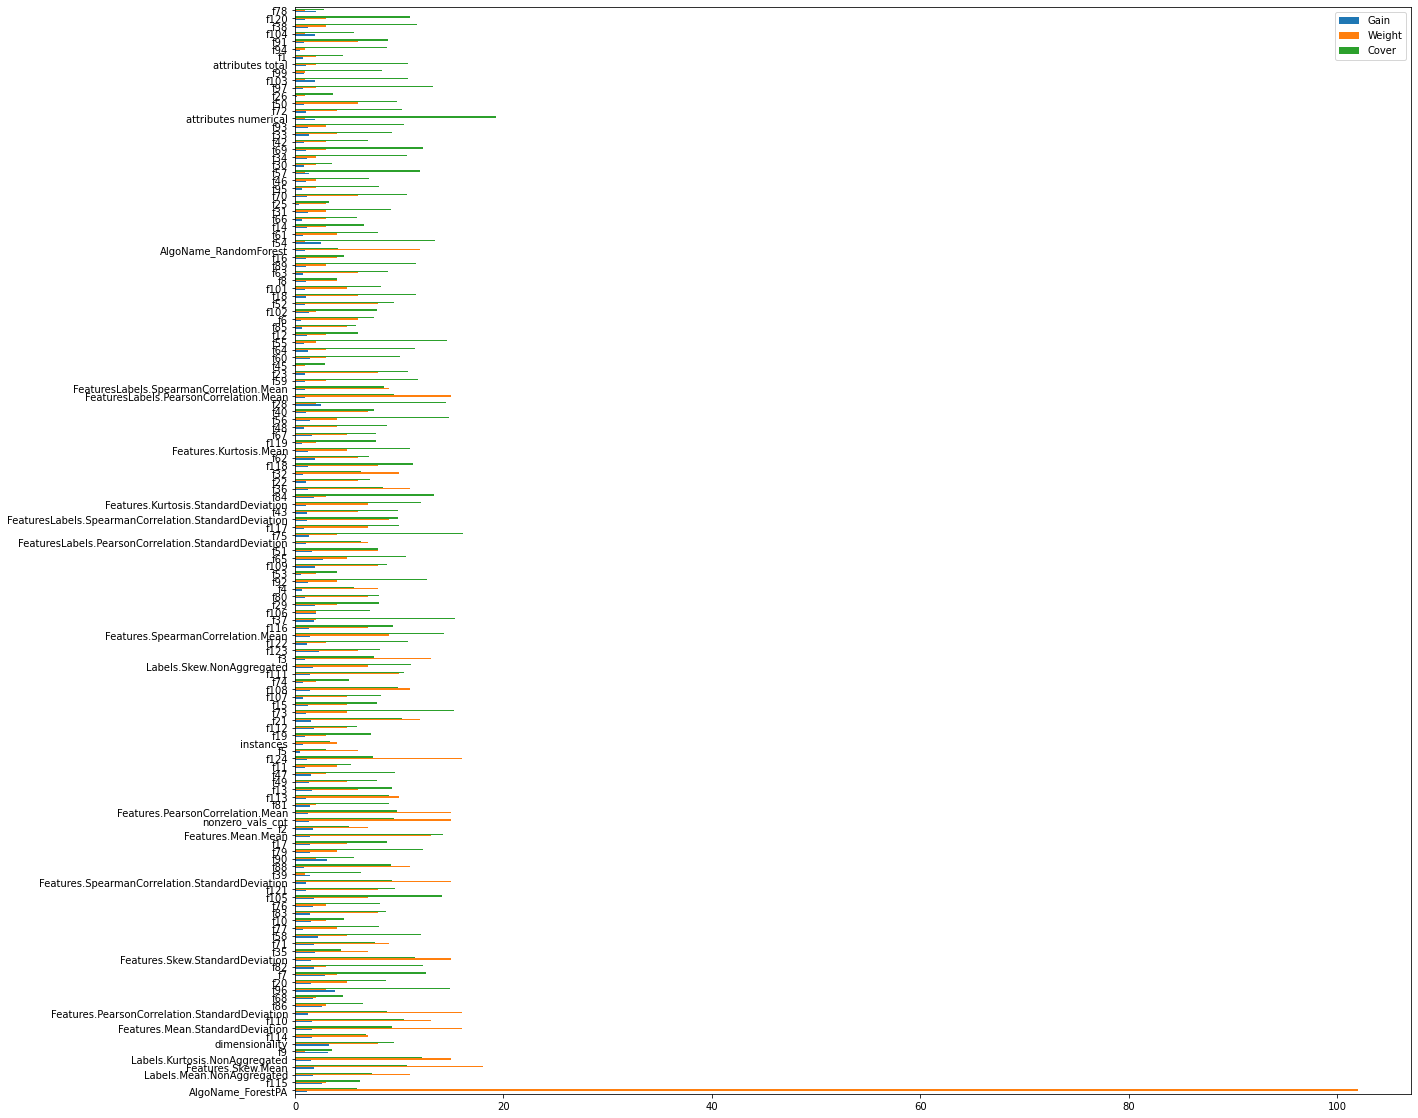

In [50]:
xgb_f_importance_df.plot(kind="barh", figsize=(20,20))

In [51]:
import shap
shap.initjs()

In [52]:

# https://github.com/slundberg/shap/issues/1215
xgb_clf_booster = xgb_clf.best_estimator_.get_booster()    
xgb_clf_booster_bytearray = xgb_clf_booster.save_raw()[4:]
def myfun(self=None):
    return xgb_clf_booster_bytearray
xgb_clf_booster.save_raw = myfun

# Shap explainer initilization
shape_explainer = shap.TreeExplainer(xgb_clf_booster)
# explainer = shap.TreeExplainer(xgb_clf.best_estimator_)
shap_values = shape_explainer.shap_values(X_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [53]:
shap.force_plot(shape_explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

In [54]:
shap.force_plot(shape_explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

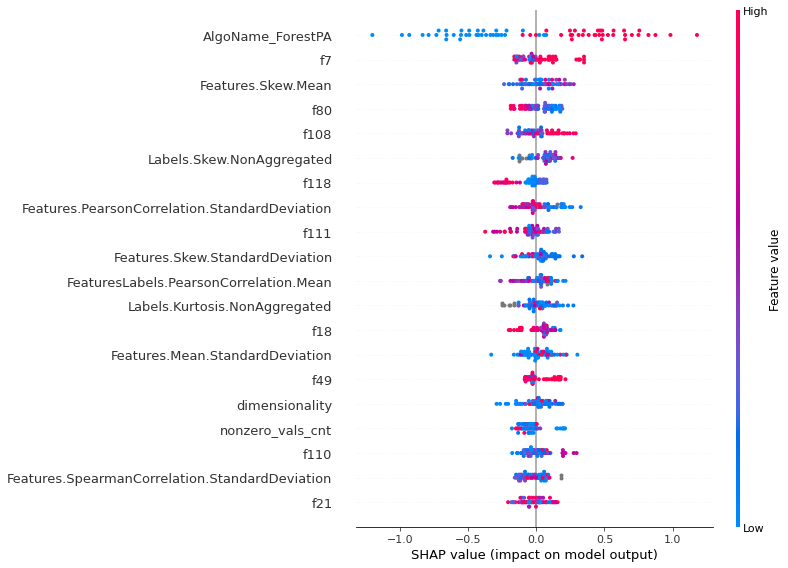

In [55]:
shap.summary_plot(shap_values, X_test)

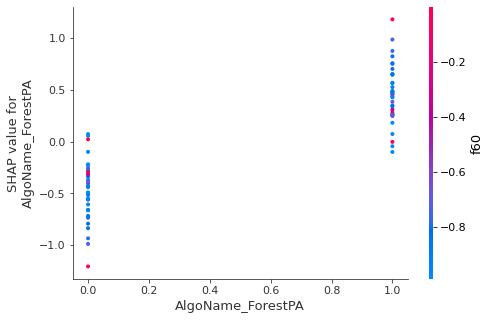

In [56]:
shap.dependence_plot("AlgoName_ForestPA", shap_values, X_test)

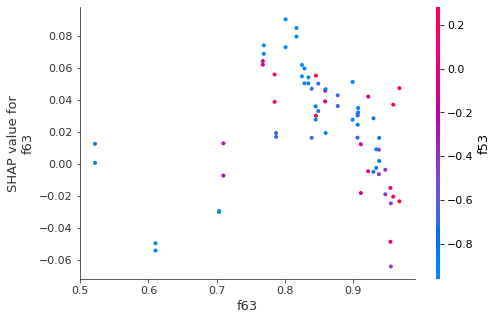

In [57]:
shap.dependence_plot("f63", shap_values, X_test)